In [2]:
!gdown --id 1b_18ujebDVXDxLuUqwN03Ahqh6qlQGak

Downloading...
From: https://drive.google.com/uc?id=1b_18ujebDVXDxLuUqwN03Ahqh6qlQGak
To: /content/store-sales-time-series-forecasting.zip
100% 22.4M/22.4M [00:00<00:00, 43.3MB/s]


In [3]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [4]:
!pip install -q darts

     |████████████████████████████████| 322 kB 8.0 MB/s 
     |████████████████████████████████| 791 kB 54.4 MB/s 
     |████████████████████████████████| 155 kB 59.9 MB/s 
     |████████████████████████████████| 9.8 MB 40.6 MB/s 
     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 177 kB 68.8 MB/s 
     |████████████████████████████████| 11.2 MB 44.6 MB/s 
     |████████████████████████████████| 1.4 MB 50.2 MB/s 
     |████████████████████████████████| 374 kB 49.2 MB/s 
     |████████████████████████████████| 890 kB 70.8 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0

In [5]:
!pip install -q matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 6.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.15.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/content/train.csv')

In [12]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
df_store = df[df['store_nbr']==1]
df_family = df_store[df['family']=='AUTOMOTIVE']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [11]:
df_family.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0


In [22]:
series = TimeSeries.from_dataframe(df_family,'date','sales',fill_missing_dates=True,fillna_value=0)

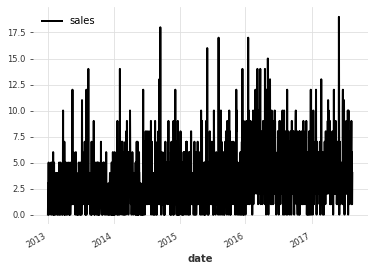

In [23]:
series.plot()

In [24]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('20170501'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=2000),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='day', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('20170501'))

In [25]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=30,
    force_reset=True
)

In [26]:
my_model.fit(train_transformed,
             future_covariates=covariates,
             verbose=True)

[2022-01-03 08:04:05,109] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1562 samples.
[2022-01-03 08:04:05,109] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1562 samples.
[2022-01-03 08:04:05,116] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-03 08:04:05,116] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 1/500 [00:01<09:38,  1.16s/it]

  2%|▏         | 11/500 [00:12<09:25,  1.16s/it]

  4%|▍         | 21/500 [00:24<09:17,  1.16s/it]

  6%|▌         | 31/500 [00:36<09:12,  1.18s/it]

  8%|▊         | 41/500 [00:47<08:52,  1.16s/it]

 10%|█         | 51/500 [00:59<08:40,  1.16s/it]

 12%|█▏        | 61/500 [01:10<08:27,  1.16s/it]

 14%|█▍        | 71/500 [01:22<08:21,  1.17s/it]

 16%|█▌        | 81/500 [01:34<08:12,  1.17s/it]

 18%|█▊        | 91/500 [01:46<08:10,  1.20s/it]

 20%|██        | 101/500 [01:57<07:48,  1.17s/it]

 22%|██▏       | 111/500 [02:09<07:28,  1.15s/it]

 24%|██▍       | 121/500 [02:21<07:21,  1.17s/it]

 26%|██▌       | 131/500 [02:32<07:07,  1.16s/it]

 28%|██▊       | 141/500 [02:44<07:07,  1.19s/it]

 30%|███       | 151/500 [02:56<06:46,  1.16s/it]

 32%|███▏      | 161/500 [03:07<06:34,  1.16s/it]

 34%|███▍      | 171/500 [03:19<06:23,  1.16s/it]

 36%|███▌      | 181/500 [03:31<06:07,  1.15s/it]

 38%|███▊      | 191/500 [03:42<05:58,  1.16s/it]

 40%|████      | 201/500 [03:54<05:47,  1.16s/it]

 42%|████▏     | 211/500 [04:05<05:36,  1.16s/it]

 44%|████▍     | 221/500 [04:17<05:22,  1.16s/it]

 46%|████▌     | 231/500 [04:29<05:10,  1.16s/it]

 48%|████▊     | 241/500 [04:40<04:59,  1.16s/it]

 50%|█████     | 251/500 [04:52<04:49,  1.16s/it]

 52%|█████▏    | 261/500 [05:03<04:37,  1.16s/it]

 54%|█████▍    | 271/500 [05:15<04:24,  1.15s/it]

 56%|█████▌    | 281/500 [05:27<04:12,  1.15s/it]

 58%|█████▊    | 291/500 [05:38<04:00,  1.15s/it]

 60%|██████    | 301/500 [05:50<03:49,  1.15s/it]

 62%|██████▏   | 311/500 [06:01<03:37,  1.15s/it]

 64%|██████▍   | 321/500 [06:13<03:25,  1.15s/it]

 66%|██████▌   | 331/500 [06:24<03:14,  1.15s/it]

 68%|██████▊   | 341/500 [06:36<03:04,  1.16s/it]

 70%|███████   | 351/500 [06:47<02:52,  1.16s/it]

 72%|███████▏  | 361/500 [06:59<02:40,  1.15s/it]

 74%|███████▍  | 371/500 [07:12<03:47,  1.76s/it]

 76%|███████▌  | 381/500 [07:25<02:19,  1.17s/it]

 78%|███████▊  | 391/500 [07:36<02:05,  1.15s/it]

 80%|████████  | 401/500 [07:48<01:54,  1.15s/it]

 82%|████████▏ | 411/500 [07:59<01:42,  1.15s/it]

 84%|████████▍ | 421/500 [08:11<01:30,  1.15s/it]

 86%|████████▌ | 431/500 [08:22<01:19,  1.16s/it]

 88%|████████▊ | 441/500 [08:34<01:07,  1.15s/it]

 90%|█████████ | 451/500 [08:45<00:56,  1.15s/it]

 92%|█████████▏| 461/500 [08:57<00:45,  1.16s/it]

 94%|█████████▍| 471/500 [09:08<00:33,  1.15s/it]

 96%|█████████▌| 481/500 [09:20<00:21,  1.15s/it]

 98%|█████████▊| 491/500 [09:31<00:10,  1.15s/it]

100%|██████████| 500/500 [09:42<00:00,  1.16s/it]


In [27]:
predicted = my_model.predict(n=len(val_transformed))

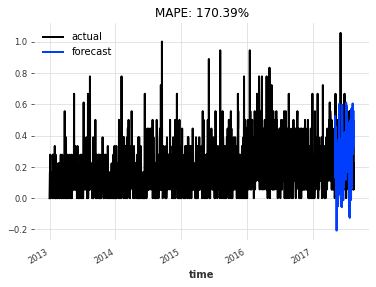

In [28]:
series_transformed.plot(label='actual')
predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(predicted, val_transformed)))
plt.legend()
plt.show()